**<center>Universidade Federal do Pará</center>**

**Curso:** Engenharia Elétrica

**Disciplina:** Laboratório De Sistemas De Controle

**Docente:** Cleison Daniel Silva

**Discentes:** 

Hilda Beatriz Viana De Oliveira - 201933940028

Ivanildo dos Santos Bento - 201833940019      

Natã Nazareno Brito Barbosa - 201933940016

**Cidade:** Tucuruí/PA                  
**Turma:** 2019

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time as t
from scipy.signal import square,sawtooth


# Controlador PI

Função de Transferência de Controlador PI:

$$ G_c (s) = \frac{K_c (s + a)}{s} \tag{B}$$

Discretização para $T_s$, período de amostragem. 

1. Forward Differences
$$G_c(z) = G_c(s)|_{s = \frac{z - 1}{T_s}}$$
2. Backwards Differences
$$G_c(z) = G_c(s)|_{s = \frac{1}{T_s} \frac{z - 1}{z}}$$
3. Trapezoidal (Tustin)
  $$G_c(z) = G_c(s)|_{s = \frac{2}{T_s} \frac{z - 1}{z + 1}}$$

No domínio $z$, temos, 
$$\frac{U(z)}{E(z)} = \frac{b_0 z + b_1}{z - 1} \frac{z^{-1}}{z^{-1}} $$


no tempo discreto, a Equação de Diferenças:

$$ u(k) = u(k-1) + b_0 e(k) + b_1 e(k-1)$$ 


In [13]:
import control as ct
Ts = 0.02                   # TEMPO DE AMOSTRAGEM!!
Kc = 2.0196                 # Nosso controlador 
a = 22.4363                 # Nossos zeros
 
Gc = ct.tf([Kc*1,Kc*a],[1,0])     # Função de transferência          
Gc

TransferFunction(array([ 2.0196    , 45.31235148]), array([1, 0]))

In [14]:
Gz = ct.c2d(Gc,Ts, 'tustin')

print('Função de Transferência do controlador: \n', Gz)

Função de Transferência do controlador: 
 
2.473 z - 1.566
---------------
     z - 1

dt = 0.02




Estabelecendo conexão.

Iniciando coleta.


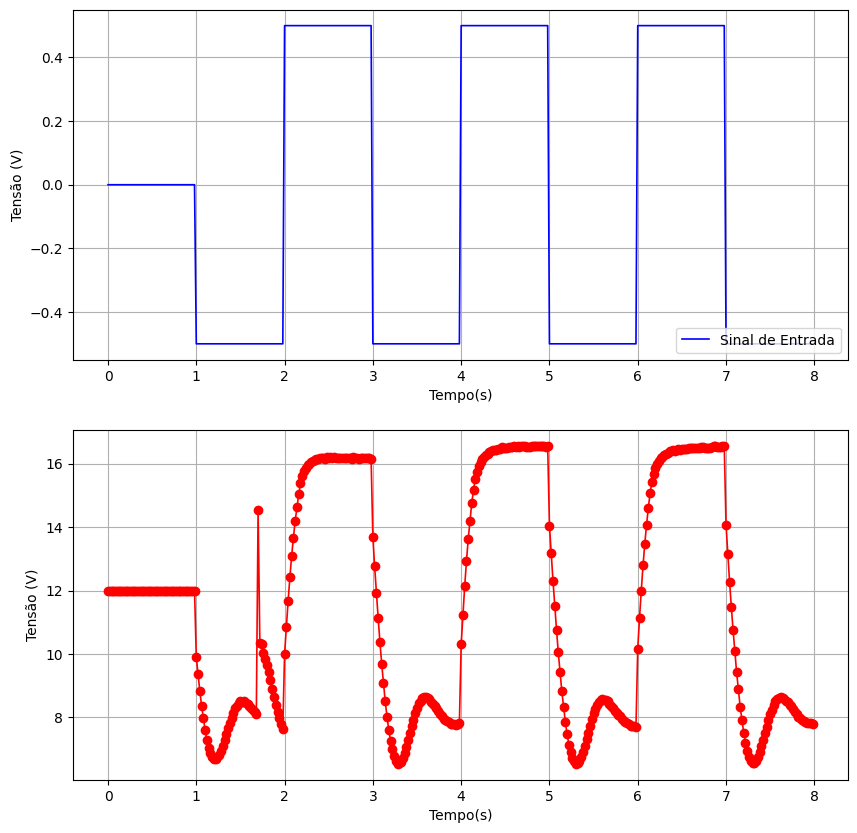

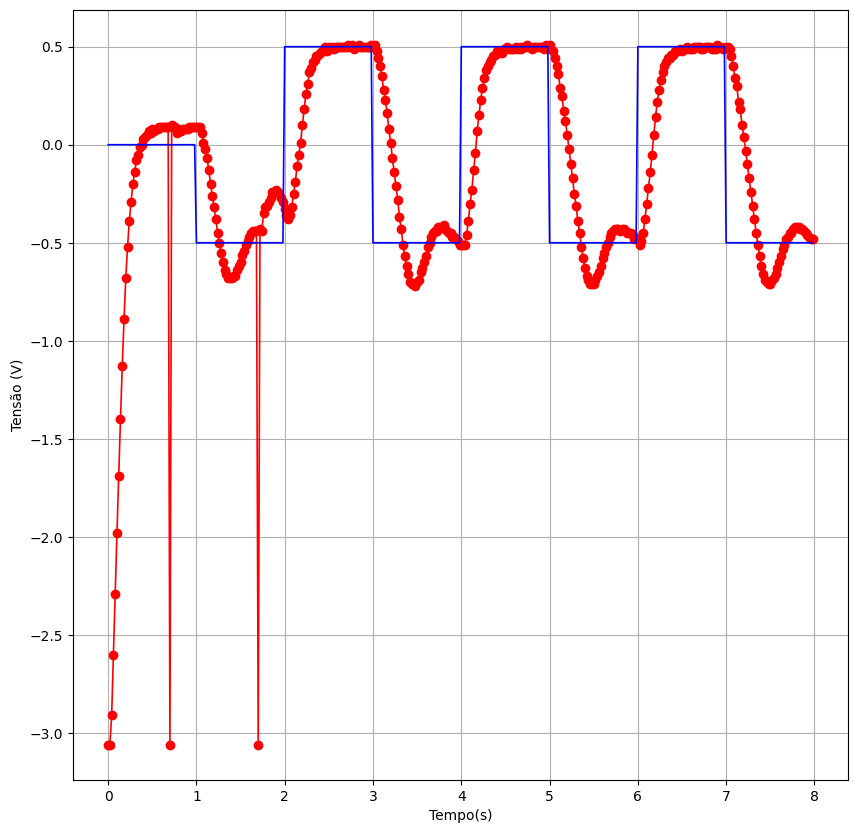

In [38]:


import serial
import numpy as np
import matplotlib.pyplot as plt
import time as t
from scipy.signal import square,sawtooth


##########################################
# Tensão de alimentação da bancada
amplitude_maxima = 15

numAmostras = 400
tempo = np.zeros(numAmostras)
y = np.zeros(numAmostras)

Ts = 0.02       
fre = 0.5                    # Freq
Amplitude = 0.5              # Amplitude
ponto_de_operacao = 12       # Bancada 05  
 
nivel_dc_saida = 3.06        # Bancada 05

#a = 2*np.ones(int(numAmostras/2))
#b = 4*np.ones(int(numAmostras/2))
#u = np.concatenate([a,b]) #degrau
r = np.zeros(numAmostras)
u = np.zeros(numAmostras)
e = np.zeros(numAmostras)
delta_u = np.zeros(numAmostras)

toc = np.zeros(numAmostras)
######################


for n in range(numAmostras):
    r[n] = Amplitude*square(2*np.pi*fre*n*Ts)
    #r[n] = Amplitude*sawtooth(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = Amplitude*np.sin(2*np.pi*fre*n*Ts) + setpoint
    #r[n] = u[n]
    
print('\nEstabelecendo conexão.')
conexao = serial.Serial(port='COM10', baudrate=9600, timeout=0.005)

t.sleep(1)
print('\nIniciando coleta.')

##_____________ Loop principal de controle _____________##
nivel_dc_entrada = ponto_de_operacao
# Gz = ct.c2d(Gc,Ts, 'tustin')
# b0 = Gz.num[0][0][0]
# b1 = Gz.num[0][0][1]


for n in range(numAmostras):
    tic = t.time()

    if (conexao.inWaiting() > 0):
        y[n] = conexao.readline().decode()

    # remove o nivel_dc_saida
    sinal_medido = y[n] - nivel_dc_saida
    
    # calcula o erro
    e[n] = r[n] - sinal_medido

    # primeiras 50 amostras
    if (n<50):
      u[n] = nivel_dc_entrada
      r[n] = 0.0
    else:
      delta_u[n] = delta_u[n-1] + 2.473*e[n] - 1.566*e[n-1]
      u[n] = nivel_dc_entrada + delta_u[n]   

    if (u[n] > amplitude_maxima):
      sinal_PWM = 255
    else:
      sinal_PWM = ((u[n])*255)/amplitude_maxima

    # sinal_PWM deve ser um número inteiro entre 0 e 255  
    conexao.write(str(round(sinal_PWM)).encode())
    
    t.sleep(Ts)
    
    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic
t.sleep(1)
conexao.write('0'.encode())


plt.figure(figsize=(10,10))                                         
plt.subplot(211)                                                                  
plt.plot(tempo,r,'-b',linewidth=1.2)                                         
plt.xlabel('Tempo(s)')                                                       
plt.ylabel('Tensão (V)')                        
plt.grid()                                                                         
#plt.title('Onda Quadrada - Malha Aberta')                                          
plt.legend(loc='lower right', labels=('Sinal de Entrada','Sinal de Saída'))                                
                        
plt.subplot(212)                             
#plt.plot(tempo,r,'-b',tempo,y,'-r',linewidth=1.2)                         
plt.plot(tempo,u,'-ro',linewidth=1.2)                   
plt.xlabel('Tempo(s)')                        
plt.ylabel('Tensão (V)')                                                            
plt.grid()                                                     
# plt.title('Tensão de Saída - Malha Aberta')
plt.show()                                                                   
                
plt.figure(figsize=(10,10))                                 
#plt.plot(tempo,r,'-b',tempo,y,'-r',linewidth=1.2)
plt.plot(tempo,y-nivel_dc_saida,'-ro', tempo, r,'-b',linewidth=1.2)                                   
plt.xlabel('Tempo(s)')                                                                                                                                           
plt.ylabel('Tensão (V)')                                                                      
plt.grid()                                                                    
# plt.title('Tensão de Saída - Malha Aberta')
plt.show() 

O controle PI é bem mais interresante que os demais, em boa parte do sinal, o controlador tenta empenhar seu papel, mais ainda assim, o sistema que está sendo trabalhado precisa ser melhor analisado e indicar uma melhor controlabilidade. 